# MLS toyblocks demo

Notebook creator: Hannah Weiser, 2025

This demo uses a toy scene, which will be scanned by ground-based mobile laser scanning (MLS).

In [1]:
import helios
from helios.platforms import DynamicPlatformSettings  # these should not have to be imported extra?
from helios.settings import OutputFormat, LogVerbosity # these should not have to be imported extra?
import numpy as np
import matplotlib.pyplot as plt

## Creating the virtual scene

In [2]:
# load objs and create transformations
groundplane = helios.ScenePart.from_obj(
    "../data/sceneparts/basic/groundplane/groundplane.obj"
).scale(70).translate([20.0, 0.0, 0.0])
cube = helios.ScenePart.from_obj("../data/sceneparts/toyblocks/cube.obj")
cube2 = helios.ScenePart.from_obj(
    "../data/sceneparts/toyblocks/cube.obj"
).scale(0.5).rotate(axis=(0.0, 0.0, 1.0), angle=45).translate([-45.0, 10.0, 10-0])
sphere = helios.ScenePart.from_obj("../data/sceneparts/toyblocks/sphere.obj").scale(0.5)
cylinder = helios.ScenePart.from_obj("../data/sceneparts/toyblocks/cylinder.obj")

# create scene
scene = helios.StaticScene(scene_parts=[groundplane, cube, cube2, sphere, cylinder])

## Platform and Scanner

In [3]:
from helios.scanner import riegl_vux_1ha22
from helios.platforms import vmq_1ha_car

scanner = riegl_vux_1ha22()
platform = vmq_1ha_car()

## Scanner Settings

In [4]:
# these scanner settings will be shared between all legs
scanner_settings = helios.ScannerSettings(pulse_frequency=100_000,  # Hz
                                          scan_frequency=50,  # Hz
                                          scan_angle=180 * helios.units.deg,
                                          head_rotation=0,  # °/s
                                          trajectory_time_interval=0.05  # s
                                         )

## Survey Route

In [5]:
survey = helios.Survey(scanner=scanner, platform=platform, scene=scene)

In [6]:
waypoints = [
    [-30, 65.0, 0],
    [-25.0, -30.0, 0],
    [1.0, -30.0, 0],
    [31.0, 0.0, 0],
    [73.5, 0.0, 0]
]
for x, y, z in waypoints:
    platform_settings = DynamicPlatformSettings(x=x, y=y, z=z, speed_m_s=20)
    leg = helios.Leg(scanner_settings=scanner_settings,
                    platform_settings=platform_settings)
    survey.add_leg(leg)

## Executing the survey

In [7]:
points, trajectories = survey.run(verbosity=LogVerbosity.VERBOSE, format=OutputFormat.NPY)

## Visualizing the results

### Color by Object ID

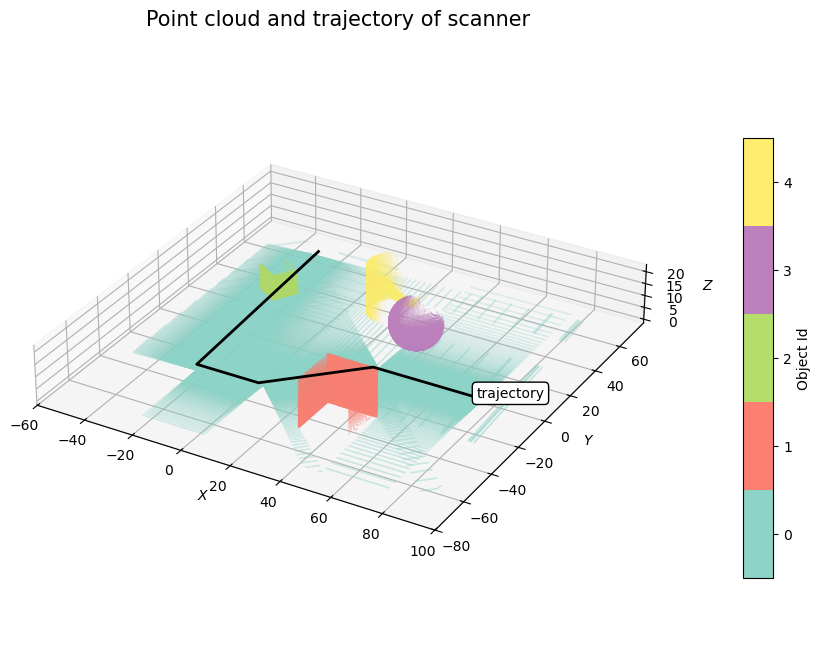

In [8]:
fig = plt.figure(figsize=(12, 8))
# 3d plot
ax = fig.add_subplot(projection="3d", computed_zorder=False)

# settings for a discrete colorbar
N = 5
cmap = plt.get_cmap("Set3", N)

# scatter plot of points
pos = points["position"]
sc = ax.scatter(
    pos[:, 0],
    pos[:, 1],
    pos[:, 2],
    c=points["hit_object_id"],
    cmap=cmap,
    s=0.02,
    zorder=1,
)

traj = trajectories["position"]
# Plot of trajectory
ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], c="black", linewidth=2, zorder=2)

cax = plt.axes([0.85, 0.2, 0.025, 0.55])
cbar = plt.colorbar(sc, cax=cax, ticks=[2 / 5, 6 / 5, 2, 2 + 4 / 5, 4 - 2 / 5])
cbar.ax.set_yticklabels(["0", "1", "2", "3", "4"])
cbar.set_label("Object Id")

# Add axis labels.
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("$Z$")

# set equal axes
box = (np.ptp(pos[:, 0]), np.ptp(pos[:, 1]), np.ptp(pos[:, 2]))
ax.set_box_aspect(box)

# Set title.
ax.set_title(label="Point cloud and trajectory of scanner", fontsize=15)
ax.text(
    traj[-1, 0],
    traj[-1, 1],
    traj[-1, 2],
    "trajectory",
    bbox=dict(boxstyle="round", fc="w", ec="k"),
    size="10",
)

# Display results
plt.show()

### Color by GPS Time

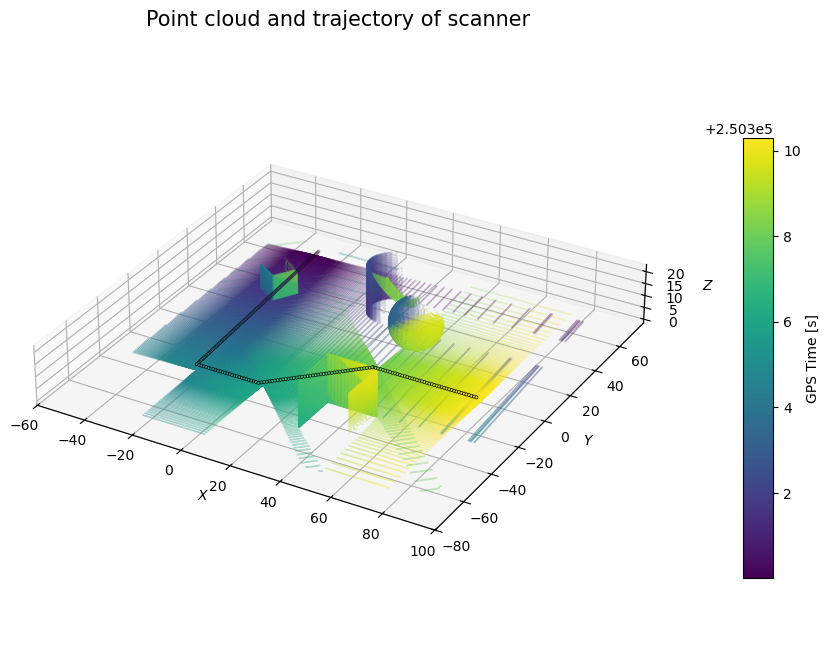

In [9]:
# Matplotlib figure
fig = plt.figure(figsize=(12, 8))
# Axes3d axis onto mpl figure.
ax = fig.add_subplot(projection="3d", computed_zorder=False)

# Scatter plot of points (coloured by GPS time)
time = points["gps_time"]
sc_pc = ax.scatter(
    pos[:, 0], pos[:, 1], pos[:, 2], c=time, s=0.02, zorder=1
)

# Plot of trajectory.
sc_traj = ax.scatter(
    traj[:, 0], traj[:, 1], traj[:, 2], c=trajectories["gps_time"], s=5, zorder=2, lw=0.5
)
sc_traj.set_edgecolor("black")

cax = plt.axes([0.85, 0.2, 0.025, 0.55])
cbar = plt.colorbar(sc_pc, cax=cax)
cbar.set_label("GPS Time [s]")

# Add axis labels.
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("$Z$")

# set equal axes
ax.set_box_aspect(box)

# Set title.
ax.set_title(label="Point cloud and trajectory of scanner", fontsize=15)

# Display results
plt.show()

### Color by strip ID

[not implemented]